[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marekadamczyk44/ml_uwr/blob/main/Assignments/Assignment2.3.ipynb)

# Bonus Lab Assignment 2.3 

**Submission deadline:**
* **lab session in the week 20-24.12.21**

**Points: 6 points**

The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

## Heads Up!

This assignment comes with starter code, but you are not forced to use it, as long as you execute all analysis demanded in the problems.

In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [ ]:
# Standard IPython notebook imports
import itertools
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn import datasets
from tqdm.auto import tqdm

import httpimport

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.gradients import check_gradient
    from common.plotting import plot_mat

sns.set_style("whitegrid")

# Problem 1 [1-6p]



Let us focus again on linear regression. Recall the two objective functions with which you can measure the fit of your line to the data. Mean Square Error: $\frac{1}{N}\sum_{i=1}^N (y^{(i)} - x^{(i)}\Theta)^2,$ 
and Mean Absolute Error: $\frac{1}{N}\sum_{i=1}^N \left | y^{(i)} - x^{(i)}\Theta \right|$.

Hence you can write the loss function more general $$\frac{1}{N}\sum_{i=1}^N L\left(y^{(i)} - x^{(i)}\Theta\right),$$ where $L(x) = x^2$ for measuring the error for the mean square criterion, and $L(x) = |x|$ for the mean absolute criterion.

Mean Square error criterion works very well if the errors are distributed according to a Gaussian distribution. However, as pointed out in the lecture, it works very poorly in case of the outliers. On the other hand Mean Absolute Error criterion is note affected for the outliers, however it assumes that the errors are distributed according to the Laplace distribution which is not always the case.
The best of both worlds is obtained with Huber loss, where 
$$
L (a) = \begin{cases}
 \frac{1}{2}{a^2}                   & \text{for } |a| \le \delta, \\
 \delta (|a| - \frac{1}{2}\delta), & \text{otherwise.}
\end{cases}
$$ for some parameter $\delta$.
And this idea can also be implemented via pseudo Huber loss of $\delta\left(\sqrt{\left(\frac{x}{\delta}\right)^2 + 1} - 1\right)$.





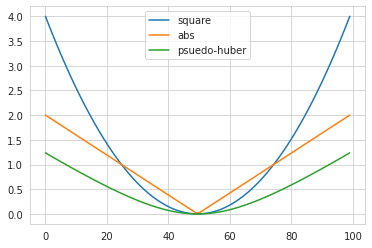

In [ ]:
import pandas as pd
import numpy as np

x = np.linspace(-2, 2, 100)
L = pd.DataFrame()
L["square"] = x**2
L["abs"] = abs(x)
L["psuedo-huber"] = np.sqrt(x**2+1)-1 
L.plot()

Hence, it seems like the amount of functions that can be used to model errors in linear regression is very vast, and that's actually the case.

In the paper [General Robust loss function](https://arxiv.org/abs/1701.03077) a function that generalizes all of these functions is presented. 

In [ ]:
#filling this cell is part of Task 1

def rho(x, alpha, c): #the general robust loss function
    if alpha == 2.0:
        return 0.5 * np.square(x / c)
    if alpha == 0.0:
        return np.log(0.5 * np.square(x / c) + 1.0)
    return np.abs(alpha - 2.0) / alpha * (np.power(np.square(x / c) / np.abs(alpha - 2.0) + 1.0, 0.5 * alpha) - 1.0)

def d_rho(x, alpha, c): #and its derivative
    if alpha == 2.0:
        return x / np.square(c)
    if alpha == 0.0:
        return (2 * x) / (np.square(x) + 2.0 * np.square(c))
    return x / np.square(c) * np.power(np.square(x / c) / np.abs(alpha - 2.0) + 1.0, 0.5 * alpha - 1)



The function $\rho$ is parametrized with $\alpha$ and $c$. Different values of $\alpha$ correspond to different shapes of the function:


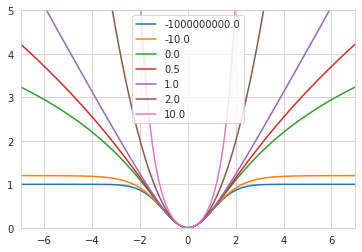

In [ ]:
x = np.linspace(-7, 7, 100)
R = pd.DataFrame(index=x)
for alpha in [-1e+9, -10, 0, 0.5, 1., 2., 10.]:
    R[alpha] = rho(x, alpha, c=1.)
R.plot(xlim=(-7,7),ylim=(0,5))

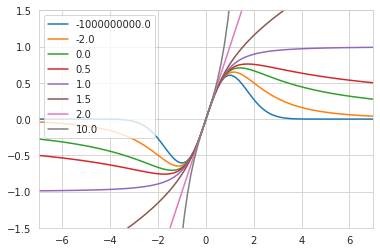

In [ ]:
x = np.linspace(-7, 7, 100)
d_R = pd.DataFrame(index=x)
for alpha in [-1e+9, -2, 0, 0.5, 1., 1.5, 2., 10.]:
    d_R[alpha] = d_rho(x, alpha, c=1.)
d_R.plot(xlim=(-7,7),ylim=(-1.5,1.5))

## Task 1 [1p]
Implement the $\rho$ function from the paper, and its derivative.

## Task 2 [1p]

For different values of $alpha$ (and $c=1$) fit $\rho(\cdot,alpha,c)$ into the house dataset

In [ ]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/assignment3/03-house-prices-outliers.csv",
    index_col=0,
)
data.head()

,rooms,area,price
0,3,66.80,367.801
1,3,55.03,289.458
2,4,70.80,389.000
3,1,29.02,195.695
4,2,45.76,265.754


In [ ]:
X = np.stack((np.ones_like(data.area), data.area)).T
Y = np.asarray(data.price)
X, Y

(array([[ 1.  , 66.8 ],
        [ 1.  , 55.03],
        [ 1.  , 70.8 ],
        ...,
        [ 1.  , 46.7 ],
        [ 1.  , 50.41],
        [ 1.  , 48.1 ]]),
 array([367.801, 289.458, 389.   , ..., 266.   , 267.1  , 269.   ]))

In [ ]:
def linreg_general_loss(Theta, X, Y, alpha, c):
    preds = X @ Theta
    errs = preds - Y
    loss, dloss_derrs = rho(errs, alpha, c).sum(), d_rho(errs, alpha, c)
    derrs_dtheta = X
    grad = (dloss_derrs[:, np.newaxis] * derrs_dtheta).sum(axis=0)
    return loss, grad.reshape(Theta.shape)

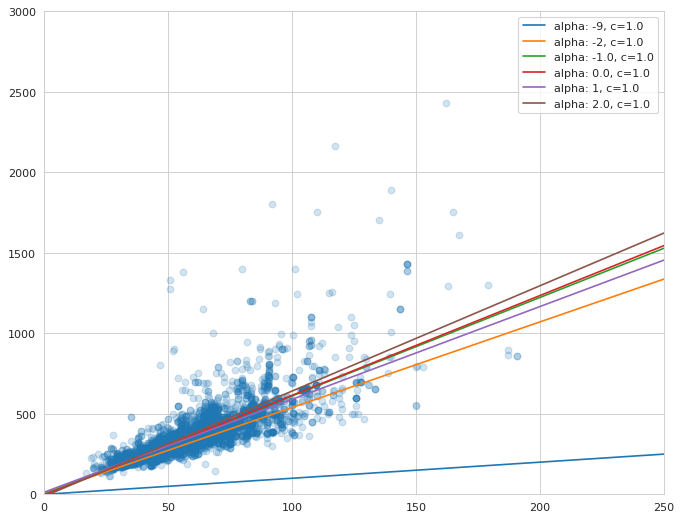

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

plt.scatter(X[:,1], Y, alpha=0.2)
area = np.linspace(0,400,1000)
Theta0 = np.asarray([-1,1])

for alpha in [-9, -2,-1., 0., 1, 2.]:
    for c in [1.]:
        ThetaOpt, _, dic = sopt.fmin_l_bfgs_b(
            lambda Theta: linreg_general_loss(Theta, X, Y, alpha=alpha+1e-9, c=c), np.array(Theta0)
        )
        price = ThetaOpt[1] * area + ThetaOpt[0]
        plt.plot(area, price, label=f"alpha: {alpha}, c={c}")

plt.xlim(0, 250)  # xlim_area[1])
plt.ylim(0, 3000)
plt.legend()


## Task 3 [1p]

As you can see in the plot above, different $\alpha$'s yield different lines. A natural question pops up: which $\alpha$ is the best?
But what does "best" even mean here? How we can quantitatively compare $\alpha$'s? Measuring the fit to the data of every line with a measure of form $$\frac{1}{N}\sum_{i=1}^N some-measure-function(y^{(i)} - x^{(i)}\Theta)$$
doesn't really make sense now.

However, we can look at it from the point of view of MLE estimators. 

As we have seen in the lecture, mean square error criterion which uses $x \mapsto x^2$ as an error measuring function corresponds to MLE under assumption that the errors are distributed according to a zero-mean normal distribution. In other words when the data $X,y$ we have was really generated by a random process such that $y_i = \Theta\cdot x_i + N(0,\sigma)$ for some $\Theta$ and some $\sigma$. And it happens that the probability density function of a normal distribution $N(0, \sigma)$ is $\frac{1}{\sigma}e^{-\frac{1}{2}\frac{x^2}{\sigma}}$

One can reproduce the proof that minimizing MSE finds MLE for normal distributions to get the proof that if the errors are distributed according to $$\frac{1}{c\cdot Z(\alpha)}e^{-\rho(x, \alpha, c)},$$ 
i.e., data is generated as $y_i = \Theta\cdot x_i + error_i$ with $error_i$ being a random variable whose probability density function is $\frac{1}{c\cdot Z(\alpha)}e^{-\rho(x, \alpha, c)}$. $Z(\alpha)$ here is a normalization constant which makes the density function integrate to $1$, that is, $Z(\alpha) = \int_{-\infty}^\infty e^{-\rho(x, \alpha, c)} \mbox{d}x$.

Reproduce this proof to get 1 point.

---
I assume that errors are distributed with zero mean.  
As we read in the paper, the general robust loss reproduces L2 loss for $\alpha=2$.

$\rho(x, \alpha, c) = \frac{1}{2} (\frac{x}{c})^2$ for $\alpha=2$

Then its PDF is
$p(x | \mu, \alpha, c) = \frac{1}{c Z(\alpha)} \exp(-\rho(x - \mu, \alpha, c) = \{\mu = 0\} = \frac{1}{c Z(\alpha)} \exp(-\rho(x, \alpha, c) = \frac{1}{c Z(\alpha)} \exp(- \frac{1}{2} (\frac{x}{c})^2 ) = \{ \alpha=2 \} = \frac{1}{c Z(2)} \exp \big(- \frac{x^2}{2c^2} \big)$


Let's recall PDF for normal distribution:
$p_N(x | \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \exp \big(- \frac{(x - \sigma)^2}{2 \sigma ^2} \big)$

Both must integrate to 1, which means that $Z(2) = \sqrt{2\pi}$. This fact is stated in equation $(18)$ in the paper. That means that by pure coincidence these distributions are identical.


Let's reproduce the proof for this distribution then.

Log-likelihood for observing all residuals/errors is: $\sum_i \log p(\Theta x_i - y_i| \mu=0, c) = \sum_i \log \exp \big(- \frac{(\Theta x_i - y_i)^2}{2c^2} \big) - n \log({c \sqrt{2\pi}}) = - \frac{\sum_i (\Theta x_i - y_i)^2}{2c^2} - n \log({c \sqrt{2\pi}})$

We clearly see that $\Theta$ maximizing log-likelihood is $\hat{\Theta}= \min_\Theta \sum_i (\Theta x_i - y_i)^2$ (mind minus sign).
This what we minimize when using L2 loss.

## Task 4 [1 vs 3p]

So now we have a clear criterion for comparing $alpha$'s. Add $\alpha$ as a parameter to the  training and find $\alpha$ and corresponding $\Theta$ that minimizes the negative log likelihood. Keep $c$ equal to $1$ everywhere, although this also can be tunable in general.

You will get 3 points if you will compute the derivative of $\rho$ over $\alpha$ and use is it in the gradient for fmin_l_bfgs_b

You will get 1 point if you will do a search over space of $alpha$'s, for every $\alpha$ you will use fmin_l_bfgs_b only for $\Theta$ and find the pair $\alpha$, $\Theta$ which maximizes the NLL.

In [ ]:
!pip install icecream
from icecream import ic

**Note** that $Z(\alpha)$ needs to be computed in the gradient, so you will need to compute the integral $\int_{-\infty}^\infty e^{-\rho(x, \alpha, c)} \mbox{d}x$.

In [ ]:
!wget https://github.com/jonbarron/robust_loss_pytorch/raw/master/robust_loss_pytorch/resources/partition_spline.npz

--2021-12-19 10:38:57--  https://github.com/jonbarron/robust_loss_pytorch/raw/master/robust_loss_pytorch/resources/partition_spline.npz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jonbarron/robust_loss_pytorch/master/robust_loss_pytorch/resources/partition_spline.npz [following]
--2021-12-19 10:38:57--  https://raw.githubusercontent.com/jonbarron/robust_loss_pytorch/master/robust_loss_pytorch/resources/partition_spline.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197188 (193K) [application/octet-stream]
Saving to: ‘partition_spline.npz’

partition_spline.np 100%[===================>] 

In [ ]:
with np.load('/content/partition_spline.npz', allow_pickle=False) as f:
    spline_x_scale = f['x_scale']
    spline_tangents = f['tangents']
    spline_values = f['values']


# this cell is stolen from https://github.com/jonbarron/robust_loss_pytorch/blob/9831f1db8006105fe7a383312fba0e8bd975e7f6/robust_loss_pytorch/cubic_spline.py#L24 and sloghtly modified to replace PyTorch with NumPy
def interpolate1d(x, values, tangents):
  r"""Perform cubic hermite spline interpolation on a 1D spline.
  The x coordinates of the spline knots are at [0 : 1 : len(values)-1].
  Queries outside of the range of the spline are computed using linear
  extrapolation. See https://en.wikipedia.org/wiki/Cubic_Hermite_spline
  for details, where "x" corresponds to `x`, "p" corresponds to `values`, and
  "m" corresponds to `tangents`.
  Args:
    x: A tensor of any size of single or double precision floats containing the
      set of values to be used for interpolation into the spline.
    values: A vector of single or double precision floats containing the value
      of each knot of the spline being interpolated into. Must be the same
      length as `tangents` and the same type as `x`.
    tangents: A vector of single or double precision floats containing the
      tangent (derivative) of each knot of the spline being interpolated into.
      Must be the same length as `values` and the same type as `x`.
  Returns:
    The result of interpolating along the spline defined by `values`, and
    `tangents`, using `x` as the query values. Will be the same length and type
    as `x`.
  """
  # if x.dtype == 'float64' or torch.as_tensor(x).dtype == torch.float64:
  #   float_dtype = torch.float64
  # else:
  #   float_dtype = torch.float32
  # x = torch.as_tensor(x, dtype=float_dtype)
  # values = torch.as_tensor(values, dtype=float_dtype)
  # tangents = torch.as_tensor(tangents, dtype=float_dtype)
#   assert torch.is_tensor(x)
#   assert torch.is_tensor(values)
#   assert torch.is_tensor(tangents)
  float_dtype = x.dtype
  assert values.dtype == float_dtype
  assert tangents.dtype == float_dtype
  assert len(values.shape) == 1
  assert len(tangents.shape) == 1
  assert values.shape[0] == tangents.shape[0]


  x_lo = np.floor(np.clip(x, 0,
                            values.shape[0] - 2)).astype(np.int64)
#   ic(x_lo)
  x_hi = x_lo + 1

  # Compute the relative distance between each `x` and the knot below it.
  t = x - x_lo.astype(np.float64) # .type(float_dtype)

  # Compute the cubic hermite expansion of `t`.
  t_sq = t**2
  t_cu = t * t_sq
  h01 = -2. * t_cu + 3. * t_sq
  h00 = 1. - h01
  h11 = t_cu - t_sq
  h10 = h11 - t_sq + t

  # Linearly extrapolate above and below the extents of the spline for all
  # values.
  value_before = tangents[0] * t + values[0]
  value_after = tangents[-1] * (t - 1.) + values[-1]

  # Cubically interpolate between the knots below and above each query point.
  neighbor_values_lo = values[x_lo]
  neighbor_values_hi = values[x_hi]
  neighbor_tangents_lo = tangents[x_lo]
  neighbor_tangents_hi = tangents[x_hi]
  value_mid = (
      neighbor_values_lo * h00 + neighbor_values_hi * h01 +
      neighbor_tangents_lo * h10 + neighbor_tangents_hi * h11)

  # Return the interpolated or extrapolated values for each query point,
  # depending on whether or not the query lies within the span of the spline.
  return np.where(t < 0., value_before,
                     np.where(t > 1., value_after, value_mid))

In [ ]:
 # c is fixed to 1 here

 def drho_dalpha(X, alpha):
    """
    X - errors
    alpha - alpha parameter of rho loss function
    c - c parameter of rho loss function # removed
    output: d(rho(X, alpha, c) / d alpha
    """
    # let's not bother with using .square() instead of ** 2
    a = alpha

    if a == 2:
        return np.zeros_like(X)
    if a == 0:
        return 0

    common_subexpr = (X ** 2.0) / (np.abs(a - 2.0)) + 1.0
    common_subexpr_pow = np.pow(common_subexpr, 0.5 * a)

    # return ((common_subexpr_pow * np.abs(a - 2.0) * (0.5 * np.log(common_subexpr) - X ** 2 * a / (2.0 * (c ** 2) * common_subexpr * np.abs(a - 2.0) * (a - 2.0)))) + (common_subexpr_pow - 1.0) * (a - 2.0) / np.abs(a - 2.0)  - np.abs(a - 2.0) * (common_subexpr_sub - 1.0) / a) / a
    term_1 = - (np.abs(a - 2) * (common_subexpr_pow - 1.0)) / (a ** 2) 
    term_2 = ((a - 2) * (common_subexpr_pow - 1) ) / (a * np.abs(a - 2))
    term_3 = (np.abs(a - 2) * common_subexpr_pow * (0.5 * np.log(common_subexpr) - ((a - 2) * a * x ** 2) / (2 * np.abs(a - 2) ** 3 * (x ** 2 / np.abs(a - 2) + 1)) ) ) / a
    return term_1 + term_2 + term_3

def drho_dX(X, alpha):
    a = alpha

    if a == 2:
        return X
    if a == 0:
        return 2 * x / (x ** 2 + 2)

    return X * np.power(X ** 2.0 / np.abs(a - 2.0) + 1.0, 0.5 * a - 1.0)

def curve(alpha):
    """
    See equation 27 in 1701.03077
    """
    a = alpha
    if a < 4:
        return (9.0 * (a - 2.0)) / (4.0 * np.abs(a - 2.0) + 1) + a + 2
    else:
        return 5.0 / 18.0 * np.log(4.0 * alpha - 15.0) + 8.0

def log_Z(alpha):
    # again this return is stolen
    x = curve(alpha)
    return interpolate1d(x * spline_x_scale,
                         spline_values,
                         spline_tangents)

from scipy.misc import derivative

def dlogZ_dalpha(alpha):
    return derivative(log_Z, alpha)

def NLL(X, alpha, c):
    return rho(X, alpha, c) + log_Z(alpha) # minuses cancel


def dNLL_dalpha(X, alpha, c):
    return drho_dalpha(X, alpha, c) + dlogZ_dalpha

def linreg_general_loss_alpha(ThetaAlpha, X, Y):
    c = 1.0
    Theta = np.array((ThetaAlpha[0], ThetaAlpha[1])) # maybe unpacking would work here?
    alpha = ThetaAlpha[2]
    ic(Theta, alpha)
    preds = X @ Theta
    errs = preds - Y
    ic(errs.shape)
    dnll_derrs = drho_dX(errs, alpha)
    ic(dnll_derrs.shape)
    ic(dnll_derrs)
    derrs_dtheta = X
    Theta_grad = (dnll_derrs[:, np.newaxis] * derrs_dtheta).sum(axis=0).reshape(Theta.shape)
    alpha_grad = dNLL_dalpha
    objective = NLL(errs, alpha, c)
    objective = objective.sum()
    grad = np.hstack([Theta_grad, np.array(alpha)])
    ic(objective)
    return objective, grad


In [ ]:
# enable debug prints
ic.enable()

In [ ]:
# disable debug prints
ic.disable()

AlphaOpt = 0.8087931288040633
ThetaOpt = [12.18318434  5.76021745]
min_mll = 183393.72452912814


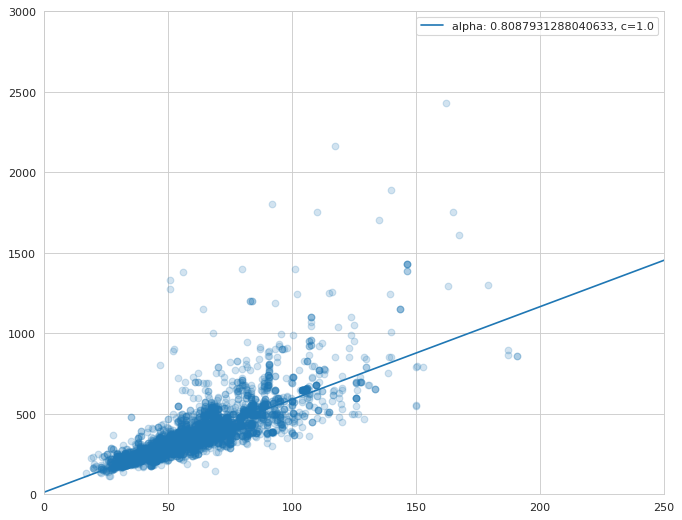

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

plt.scatter(X[:,1], Y, alpha=0.2)
area = np.linspace(0,400,1000)
ThetaAlpha0 = np.asarray([-1, 1, 1])

ThetaAlphaOpt, min_mll, _ = sopt.fmin_l_bfgs_b(
    lambda ThetaAlpha: linreg_general_loss_alpha(ThetaAlpha, X, Y), np.array(ThetaAlpha0)
)


AlphaOpt = ThetaAlphaOpt[2]
ThetaOpt = np.array((ThetaAlphaOpt[0], ThetaAlphaOpt[1]))

print(f'AlphaOpt = {AlphaOpt}')
print(f'ThetaOpt = {ThetaOpt}')
print(f'min_mll = {min_mll}')

price = ThetaAlphaOpt[1] * area + ThetaAlphaOpt[0]
plt.plot(area, price, label=f"alpha: {AlphaOpt}, c={c}")

plt.xlim(0, 250)
plt.ylim(0, 3000)
plt.legend()
